In [1]:
# Pour le calcul matricielle
import numpy as np;
import pandas as pd;

# Pour la visualisation
import seaborn as sns;
import matplotlib.pyplot as plt;

# Pour le prétraitement
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder;

# Pour sélectionner le modèle qui performe et qui généralise le mieux
from sklearn.model_selection import train_test_split, cross_val_score, KFold;

# Pour la modèlisation
from sklearn.linear_model import LinearRegression, Lasso, Ridge;
from sklearn.neighbors import KNeighborsRegressor;
from sklearn.tree import DecisionTreeRegressor;

# For save and load model
from joblib import dump, load;

# Pour l'evaluation des modèles
from sklearn.metrics import mean_squared_error;

from sklearn.utils import shuffle;
import warnings;

sns.set_style('darkgrid');
pd.set_option('max_column', None);
warnings.filterwarnings('ignore');

RANDOM_STATE = 13;

Définition du problème:
    
    * comprendre les enjeux metier
    
    Prédire le niveau de pression acoustique à partir des caractériques des ailes d'avions.
    
    1) Est ce que le niveau de pression acoustique croit lorsque la fréquence croit?
    
    faire de meme pour les autres variables
    
    
    

In [68]:
names=["Fréquence", "Angle d'attaque", "Longueur de la corde", "Vitesse", "Epaisseur", "Pression acoustique"]
df= pd.read_table("airfoil_self_noise.dat", sep="\t")

In [69]:
df= df.set_axis(names, axis=1)

In [70]:
df= shuffle(df, random_state=RANDOM_STATE)

In [71]:
df.head()

,Fréquence,Angle d'attaque,Longueur de la corde,Vitesse,Epaisseur,Pression acoustique
5,3150,0.0,0.3048,71.3,0.002663,125.201
177,630,4.0,0.3048,39.6,0.005796,131.073
1187,1250,17.4,0.0254,39.6,0.017221,131.364
649,630,9.9,0.1524,55.5,0.020844,127.315
1179,200,17.4,0.0254,39.6,0.017221,114.044


In [72]:
# taille du dataset
print(df.shape);

(1502, 6)


In [73]:
df["Vitesse"].value_counts()

39.6    480
71.3    464
31.7    281
55.5    277
Name: Vitesse, dtype: int64

In [74]:
# Let's get train and production dataset
data = df[:1300].reset_index(drop=True);
prod  = df[1300:].reset_index(drop=True);

In [9]:
# Type of varaibles
cat_cols = ["Vitesse", "Longueur de la corde"];
num_cols = [col for col in data.columns.values if col not in cat_cols + ["Pression acoustique"]];

## COMPRENDRE LES DONNÉES : statistiques descriptives et inférentielles, analyse des données, vérifier les hypothèses

In [10]:
# Verification de valeurs manquantes
data.isna().sum().any()

False

In [11]:
# Verification de doublons
data[data.duplicated(keep=False)].shape

(0, 6)

#### Analyse Exploratoire Univariée

,count,mean,std,min,25%,50%,75%,max
Pression acoustique,1300.0,124.849716,6.905327,103.38,120.2405,125.803,129.966,140.987


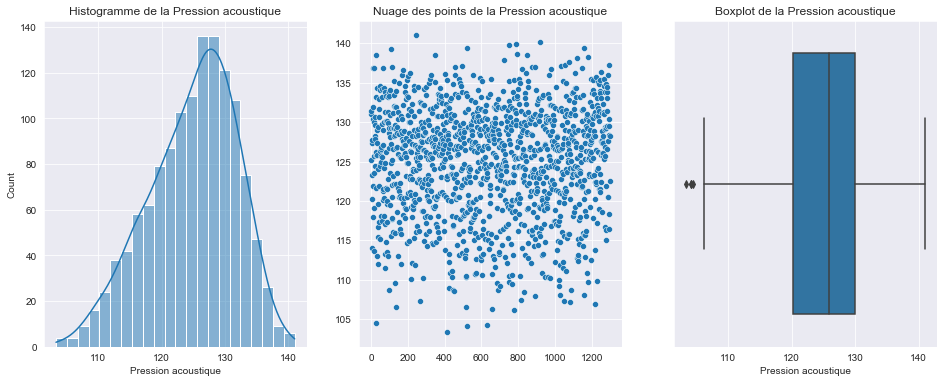

In [12]:
# Distribution de la variable cible

plt.figure(figsize=(16, 6));
plt.subplot(131);
sns.histplot(data['Pression acoustique'], kde=True);
plt.title('Histogramme de la Pression acoustique');

plt.subplot(132);
sns.scatterplot(data.index.values, data['Pression acoustique'].values)
plt.title('Nuage des points de la Pression acoustique');

plt.subplot(133);
sns.boxplot(data['Pression acoustique']);
plt.title('Boxplot de la Pression acoustique');

data[['Pression acoustique']].describe().T

In [13]:
# Stats descriptive
data[num_cols].describe()

,Fréquence,Angle d'attaque,Epaisseur
count,1300.000000,1300.000000,1300.000000
mean,2891.957692,6.824385,0.011155
std,3182.455609,5.878828,0.013132
min,200.000000,0.000000,0.000401
25%,800.000000,2.000000,0.002663
50%,1600.000000,5.400000,0.004957
75%,4000.000000,9.900000,0.016104
max,20000.000000,22.200000,0.058411


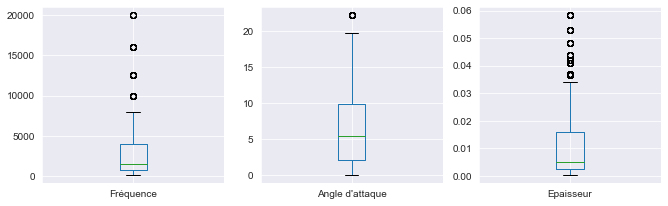

In [14]:
# Boxplot
data[num_cols].plot(kind='box', subplots=True, layout=(3,4), sharex=False, figsize=(15, 11));
plt.show()

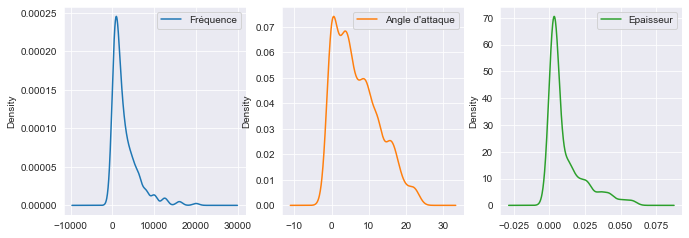

In [15]:
# Densité
data[num_cols].plot(kind='density', subplots=True, layout=(3,4), sharex=False, sharey=False, legend=True, figsize=(15, 13));
plt.show()

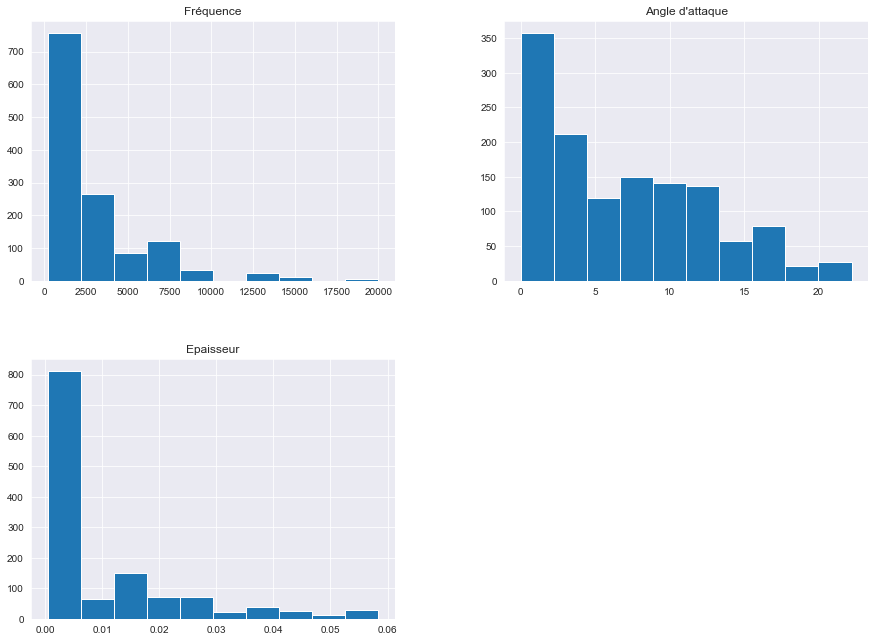

In [16]:
# Histogram
data[num_cols].hist(figsize=(15, 11));
plt.show()

## Conclusion!!!!!!

### Analyse Exploratoire Bivariée

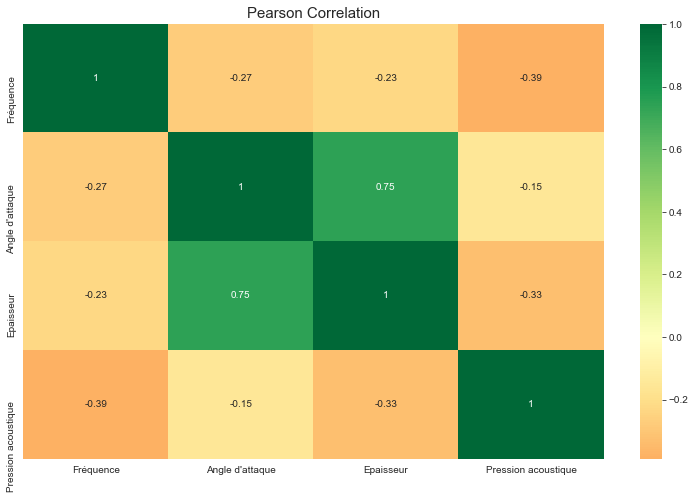

In [17]:
# Correlation matrix
corr = data[num_cols + ["Pression acoustique"]].corr(method='pearson');
plt.figure(figsize = (13, 8));
sns.heatmap(corr, cmap='RdYlGn', annot=True, center=0);
plt.title('Pearson Correlation', fontsize=15);
plt.show()

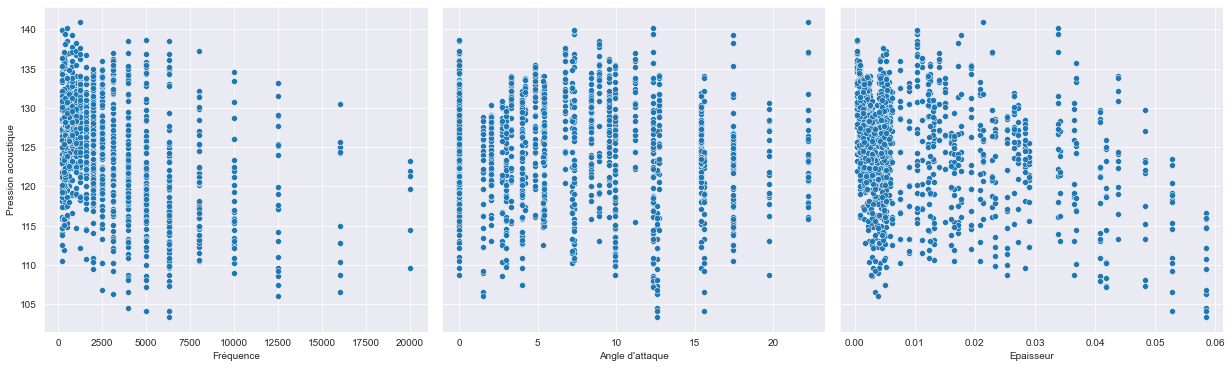

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(17, 5), sharey=True, constrained_layout=True);
axes = axes.flatten();

for col, ax in zip(num_cols, axes):
    sns.scatterplot(data[col], data['Pression acoustique'],ax=ax);
    ax.set_ylabel('Pression acoustique');
    ax.set_xlabel(col);

In [19]:
# Select main columns to be used in training
main_cols = data.columns.difference(['Pression acoustique']); 
X = data[main_cols];
y = data['Pression acoustique'];

# K-Fold
kfold = KFold(n_splits=12, shuffle=True, random_state=RANDOM_STATE);

In [20]:
# Spot-check selection
models = [];
models.append(('LR', LinearRegression()));
models.append(('KNN', KNeighborsRegressor(n_neighbors=5)));
models.append(('DT', DecisionTreeRegressor(max_depth=5, random_state=RANDOM_STATE)));

results = [];  # Store score of models
names   = [];  # Store name of models

In [21]:
# Fit
for name, model in models:
    
    scores = []; # Store score of folds
    
    for tr_idx, val_idx in kfold.split(data[main_cols]):
           
        # Get train and validation data    
        X_train = data.iloc[tr_idx][main_cols];
        y_train = data.iloc[tr_idx]["Pression acoustique"];
        
        X_val   = data.iloc[val_idx][main_cols];
        y_val   = data.iloc[val_idx]["Pression acoustique"];
        
     
        
        # Fit model
        model.fit(X_train, y_train);
        y_pred = model.predict(X_val);
        
        scores.append(mean_squared_error(y_val, y_pred)); # Save score of this fold
             
    print('%s : %.4f(%.4f)' % (name, np.mean(scores), np.std(scores)));
    
    results.append(np.abs(scores));  # Save all fold scores of this model
    names.append(name);

LR : 23.0935(4.7504)
KNN : 37.5622(5.0905)
DT : 17.8354(3.5400)


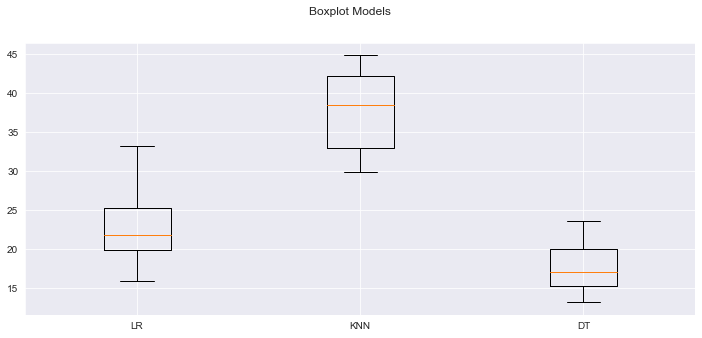

In [22]:
# Compare Algorithms
fig = plt.figure(figsize=(12,5));
fig.suptitle('Boxplot Models');
ax = fig.add_subplot(111);
plt.boxplot(results);
ax.set_xticklabels(names);

creer une variable "intensité"

faire un nuage de points de l'intensté et la pression acoustique puis faire inférence.

data["intensité"= 2*np.pi**2*(data["frequence"]**2)*1.176*(data["pression acoustique"])**2*340.29

### Nous allons à présent recommencer le travail en discretisant la variable "Epaisseur"

In [75]:
names=["Fréquence", "Angle d'attaque", "Longueur de la corde", "Vitesse", "Epaisseur", "Pression acoustique"]
df= pd.read_table("airfoil_self_noise.dat", sep="\t")

In [76]:
df= df.set_axis(names, axis=1)

In [77]:
df= shuffle(df, random_state=RANDOM_STATE)

In [79]:
# Let's get train and production dataset
data = df[:1300].reset_index(drop=True);
prod  = df[1300:].reset_index(drop=True);

In [27]:
def discretise_Ep(x):
    
    if x >= 0 and x < 0.01:
        return 0;
    elif x >= 0.01 and x < 0.03:
        return 1;
    elif x >= 0.03 and x < 0.05:
        return 2;
    else:
        return -1;

In [28]:
# Encoder Epaisseur
data['Epaisseur'] = data['Epaisseur'].apply(discretise_Ep);

prod['Epaisseur'] = prod['Epaisseur'].apply(discretise_Ep);

In [29]:
# Select main columns to be used in training
main_cols = data.columns.difference(['Pression acoustique']); 
X = data[main_cols];
y = data['Pression acoustique'];

# K-Fold
kfold = KFold(n_splits=12, shuffle=True, random_state=RANDOM_STATE);

In [30]:
# Spot-check selection
models = [];
models.append(('LR', LinearRegression()));
models.append(('KNN', KNeighborsRegressor(n_neighbors=5)));
models.append(('DT', DecisionTreeRegressor(max_depth=5, random_state=RANDOM_STATE)));

results = [];  # Store score of models
names   = [];  # Store name of models

In [31]:
# Fit
for name, model in models:
    
    scores = []; # Store score of folds
    
    for tr_idx, val_idx in kfold.split(data[main_cols]):
           
        # Get train and validation data    
        X_train = data.iloc[tr_idx][main_cols];
        y_train = data.iloc[tr_idx]["Pression acoustique"];
        
        X_val   = data.iloc[val_idx][main_cols];
        y_val   = data.iloc[val_idx]["Pression acoustique"];
        
     
        
        # Fit model
        model.fit(X_train, y_train);
        y_pred = model.predict(X_val);
        
        scores.append(mean_squared_error(y_val, y_pred)); # Save score of this fold
             
    print('%s : %.4f(%.4f)' % (name, np.mean(scores), np.std(scores)));
    
    results.append(np.abs(scores));  # Save all fold scores of this model
    names.append(name);

LR : 24.7668(4.6511)
KNN : 37.1352(4.9158)
DT : 20.2051(3.8283)


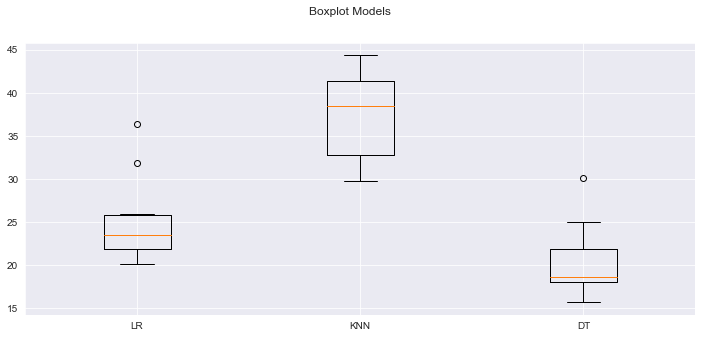

In [32]:
# Compare Algorithms
fig = plt.figure(figsize=(12,5));
fig.suptitle('Boxplot Models');
ax = fig.add_subplot(111);
plt.boxplot(results);
ax.set_xticklabels(names);

## Discretisons juste "Fréquence"

In [33]:
names=["Fréquence", "Angle d'attaque", "Longueur de la corde", "Vitesse", "Epaisseur", "Pression acoustique"]
df= pd.read_table("airfoil_self_noise.dat", sep="\t")

In [34]:
df= df.set_axis(names, axis=1)

In [35]:
df= shuffle(df, random_state=RANDOM_STATE)

In [36]:
# Let's get train and production dataset
data = df[:1300].reset_index(drop=True);
prod  = df[1300:].reset_index(drop=True);

In [37]:
def discretise_Fr(x):
    
    if x >= 0 and x < 2500:
        return 0;
    elif x >= 2500 and x < 10000:
        return 1;
    elif x >= 10000 and x < 20000:
        return 2;
    else:
        return -1;

In [38]:
# Encoder Epaisseur
data['Fréquence'] = data['Fréquence'].apply(discretise_Fr);

prod['Fréquence'] = prod['Fréquence'].apply(discretise_Fr);

In [39]:
# Select main columns to be used in training
main_cols = data.columns.difference(['Pression acoustique']); 
X = data[main_cols];
y = data['Pression acoustique'];

# K-Fold
kfold = KFold(n_splits=12, shuffle=True, random_state=RANDOM_STATE);

In [40]:
# Spot-check selection
models = [];
models.append(('LR', LinearRegression()));
models.append(('KNN', KNeighborsRegressor(n_neighbors=5)));
models.append(('DT', DecisionTreeRegressor(max_depth=5, random_state=RANDOM_STATE)));

results = [];  # Store score of models
names   = [];  # Store name of models

In [41]:
# Fit
for name, model in models:
    
    scores = []; # Store score of folds
    
    for tr_idx, val_idx in kfold.split(data[main_cols]):
           
        # Get train and validation data    
        X_train = data.iloc[tr_idx][main_cols];
        y_train = data.iloc[tr_idx]["Pression acoustique"];
        
        X_val   = data.iloc[val_idx][main_cols];
        y_val   = data.iloc[val_idx]["Pression acoustique"];
        
     
        
        # Fit model
        model.fit(X_train, y_train);
        y_pred = model.predict(X_val);
        
        scores.append(mean_squared_error(y_val, y_pred)); # Save score of this fold
             
    print('%s : %.4f(%.4f)' % (name, np.mean(scores), np.std(scores)));
    
    results.append(np.abs(scores));  # Save all fold scores of this model
    names.append(name);

LR : 25.9612(5.6338)
KNN : 23.5374(4.6147)
DT : 20.8953(3.1305)


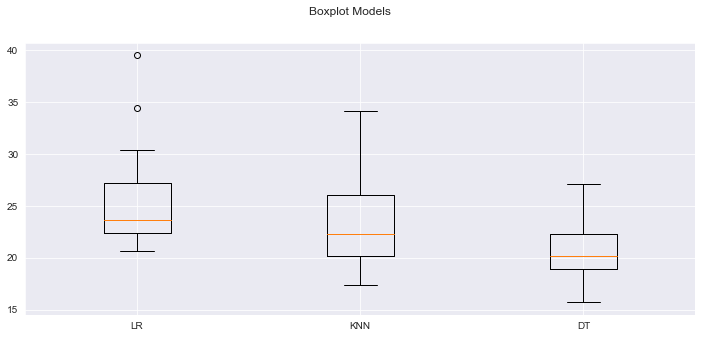

In [42]:
# Compare Algorithms
fig = plt.figure(figsize=(12,5));
fig.suptitle('Boxplot Models');
ax = fig.add_subplot(111);
plt.boxplot(results);
ax.set_xticklabels(names);

### Discretisons les deux variables

In [43]:
names=["Fréquence", "Angle d'attaque", "Longueur de la corde", "Vitesse", "Epaisseur", "Pression acoustique"]
df= pd.read_table("airfoil_self_noise.dat", sep="\t")

In [44]:
df= df.set_axis(names, axis=1)

In [45]:
df= shuffle(df, random_state=RANDOM_STATE)

In [46]:
# Let's get train and production dataset
data = df[:1300].reset_index(drop=True);
prod  = df[1300:].reset_index(drop=True);

In [47]:
def discretise_Ep(x):
    
    if x >= 0 and x < 0.01:
        return 0;
    elif x >= 0.01 and x < 0.03:
        return 1;
    elif x >= 0.03 and x < 0.05:
        return 2;
    else:
        return -1;

In [48]:
# Encoder Epaisseur
data['Epaisseur'] = data['Epaisseur'].apply(discretise_Ep);

prod['Epaisseur'] = prod['Epaisseur'].apply(discretise_Ep);

In [49]:
def discretise_Fr(x):
    
    if x >= 0 and x < 2500:
        return 0;
    elif x >= 2500 and x < 10000:
        return 1;
    elif x >= 10000 and x < 20000:
        return 2;
    else:
        return -1;

In [50]:
# Encoder Epaisseur
data['Fréquence'] = data['Fréquence'].apply(discretise_Fr);

prod['Fréquence'] = prod['Fréquence'].apply(discretise_Fr);

In [51]:
# Select main columns to be used in training
main_cols = data.columns.difference(['Pression acoustique']); 
X = data[main_cols];
y = data['Pression acoustique'];

# K-Fold
kfold = KFold(n_splits=12, shuffle=True, random_state=RANDOM_STATE);

In [52]:
# Spot-check selection
models = [];
models.append(('LR', LinearRegression()));
models.append(('KNN', KNeighborsRegressor(n_neighbors=5)));
models.append(('DT', DecisionTreeRegressor(max_depth=5, random_state=RANDOM_STATE)));

results = [];  # Store score of models
names   = [];  # Store name of models

In [53]:
# Fit
for name, model in models:
    
    scores = []; # Store score of folds
    
    for tr_idx, val_idx in kfold.split(data[main_cols]):
           
        # Get train and validation data    
        X_train = data.iloc[tr_idx][main_cols];
        y_train = data.iloc[tr_idx]["Pression acoustique"];
        
        X_val   = data.iloc[val_idx][main_cols];
        y_val   = data.iloc[val_idx]["Pression acoustique"];
        
     
        
        # Fit model
        model.fit(X_train, y_train);
        y_pred = model.predict(X_val);
        
        scores.append(mean_squared_error(y_val, y_pred)); # Save score of this fold
             
    print('%s : %.4f(%.4f)' % (name, np.mean(scores), np.std(scores)));
    
    results.append(np.abs(scores));  # Save all fold scores of this model

LR : 27.6482(5.4579)
KNN : 23.7048(4.0702)
DT : 20.1406(3.5439)


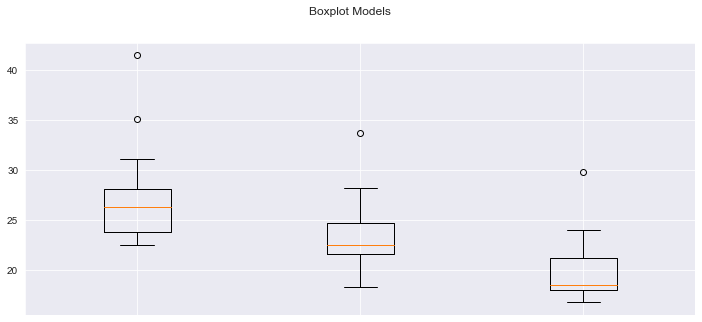

In [54]:
# Compare Algorithms
fig = plt.figure(figsize=(12,5));
fig.suptitle('Boxplot Models');
ax = fig.add_subplot(111);
plt.boxplot(results);
ax.set_xticklabels(names);

## CHOIX DES BONS MODELES

Au vu de tous les précedents modèles entrainés, nous pouvon dire que les meilleurs modèles présentent les caractéristiques suivants:
   

##### LR : 24.7668(4.6511)
##### KNN : 37.1352(4.9158)
##### DT : 20.2051(3.8283)
    


In [80]:
names=["Fréquence", "Angle d'attaque", "Longueur de la corde", "Vitesse", "Epaisseur", "Pression acoustique"]
df= pd.read_table("airfoil_self_noise.dat", sep="\t")

In [81]:
df= df.set_axis(names, axis=1)

In [82]:
df= shuffle(df, random_state=RANDOM_STATE)

In [83]:
# Let's get train and production dataset
data = df[:1300].reset_index(drop=True);
prod  = df[1300:].reset_index(drop=True);

In [84]:
prod

,Fréquence,Angle d'attaque,Longueur de la corde,Vitesse,Epaisseur,Pression acoustique
0,4000,7.3,0.2286,39.6,0.012348,114.079
1,2000,4.8,0.0254,71.3,0.000849,128.398
2,2500,0.0,0.0254,71.3,0.000401,133.707
3,2000,19.7,0.0508,71.3,0.034118,120.055
4,630,3.3,0.1016,31.7,0.002514,128.952
...,...,...,...,...,...,...
197,3150,11.2,0.0508,39.6,0.015048,119.670
198,2500,0.0,0.0508,55.5,0.000762,133.956
199,6300,1.5,0.3048,71.3,0.003367,118.122
200,500,4.0,0.3048,39.6,0.005796,130.173


In [85]:
def discretise_Ep(x):
    
    if x >= 0 and x < 0.01:
        return 0;
    elif x >= 0.01 and x < 0.03:
        return 1;
    elif x >= 0.03 and x < 0.05:
        return 2;
    else:
        return -1;

In [86]:
# Encoder Epaisseur
data['Epaisseur'] = data['Epaisseur'].apply(discretise_Ep);

prod['Epaisseur'] = prod['Epaisseur'].apply(discretise_Ep);

In [87]:
# Select main columns to be used in training
main_cols = data.columns.difference(['Pression acoustique']); 
X = data[main_cols];
y = data['Pression acoustique'];

# K-Fold
kfold = KFold(n_splits=12, shuffle=True, random_state=RANDOM_STATE);

In [88]:
# Fit the models
final_lr   = LinearRegression();
final_lr.fit(data[main_cols], data['Pression acoustique']);

final_knn  = KNeighborsRegressor(n_neighbors=5);
final_knn.fit(data[main_cols], data['Pression acoustique']);

final_dt   = DecisionTreeRegressor(max_depth=5, random_state=RANDOM_STATE);
final_dt.fit(data[main_cols], data['Pression acoustique']);

In [89]:
# Save model for production
dump(final_lr, 'final_lr');
dump(final_knn, 'final_knn');
dump(final_dt, 'final_dt');

In [90]:
prod[main_cols]

,Angle d'attaque,Epaisseur,Fréquence,Longueur de la corde,Vitesse
0,7.3,1,4000,0.2286,39.6
1,4.8,0,2000,0.0254,71.3
2,0.0,0,2500,0.0254,71.3
3,19.7,2,2000,0.0508,71.3
4,3.3,0,630,0.1016,31.7
...,...,...,...,...,...
197,11.2,1,3150,0.0508,39.6
198,0.0,0,2500,0.0508,55.5
199,1.5,0,6300,0.3048,71.3
200,4.0,0,500,0.3048,39.6


## DÉPLOIEMENT : Joblib

In [91]:
# Load model
loaded_lr = load('final_lr');
y_lr = loaded_lr.predict(prod[main_cols]);

loaded_knn = load('final_knn');
y_knn = loaded_knn.predict(prod[main_cols]);

loaded_dt = load('final_dt');
y_dt = loaded_dt.predict(prod[main_cols]);

In [93]:
# Evaluation
print(f"LR MSE Production: {mean_squared_error(prod['Pression acoustique'], y_lr)}");
print(f"KNN MSE Production: {mean_squared_error(prod['Pression acoustique'], y_knn)}");
print(f"DT MSE Production: {mean_squared_error(prod['Pression acoustique'], y_dt)}");

LR MSE Production: 24.095003550203817
KNN MSE Production: 35.481086493663376
DT MSE Production: 19.06457389878411


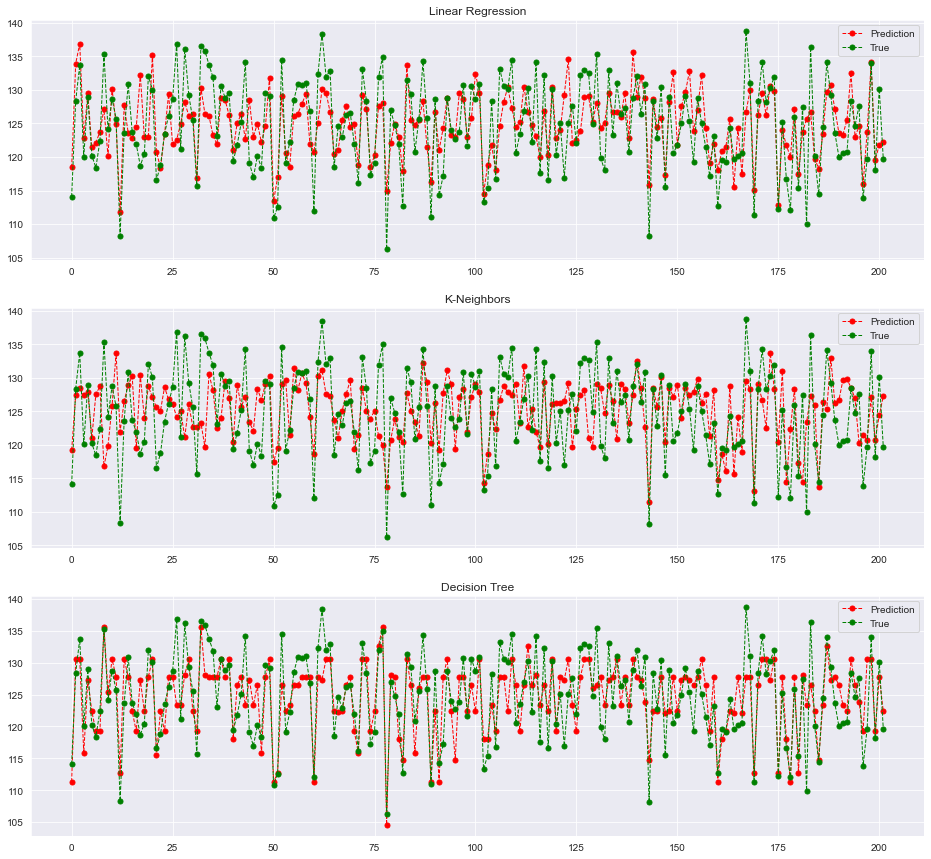

In [94]:
# Plotting predicted and true values
plt.figure(figsize=(16, 15));
plt.subplot(311);
plt.plot(np.arange(0, len(y_lr)), y_lr, 'o', linestyle='dashed', linewidth=1, color='red', markersize=5, label='Prediction');
plt.plot(np.arange(0, len(prod['Pression acoustique'])), prod['Pression acoustique'], 'o', linestyle='dashed', linewidth=1, markersize=5, color='green', label='True');
plt.legend();
plt.title('Linear Regression');

plt.subplot(312);
plt.plot(np.arange(0, len(y_lr)), y_knn, 'o', linestyle='dashed', linewidth=1, color='red', markersize=5, label='Prediction');
plt.plot(np.arange(0, len(prod['Pression acoustique'])), prod['Pression acoustique'], 'o', linestyle='dashed', linewidth=1, markersize=5, color='green', label='True');
plt.legend();
plt.title('K-Neighbors');

plt.subplot(313);
plt.plot(np.arange(0, len(y_lr)), y_dt, 'o', linestyle='dashed', linewidth=1, color='red', markersize=5, label='Prediction');
plt.plot(np.arange(0, len(prod['Pression acoustique'])), prod['Pression acoustique'], 'o', linestyle='dashed', linewidth=1, markersize=5, color='green', label='True');
plt.legend();
plt.title('Decision Tree');